In [2]:
# pip install fastkml geopandas fiona shapely lxml contextily 


In [3]:
import pandas as pd

In [4]:
kmz_filepath =  "../data/sky_island/SkyIslandComplexes.kmz"

In [5]:
import zipfile

with zipfile.ZipFile(kmz_filepath, 'r') as kmz:
    file_list = kmz.namelist()
    print(file_list)


['8C333B999F0F4117828D01DB64E722CC.xsl', 'doc.kml']


In [6]:
with zipfile.ZipFile(kmz_filepath, 'r') as kmz:
    kml_content = kmz.read('doc.kml')
    print(kml_content.decode()[:1000])


<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 xsi:schemaLocation="http://www.opengis.net/kml/2.2 http://schemas.opengis.net/kml/2.2.0/ogckml22.xsd http://www.google.com/kml/ext/2.2 http://code.google.com/apis/kml/schema/kml22gx.xsd">
<Document id="SkyIslandComplexes">
  <name>SkyIslandComplexes</name>
  <snippet></snippet>
  <description><![CDATA[]]></description>
  <Folder id="FeatureLayer0">
    <name>SkyIslandComplexes</name>
    <snippet></snippet>
    <description><![CDATA[]]></description>
    <Placemark id="ID_00000">
      <name>PELONCILLO</name>
      <snippet></snippet>
      <description><![CDATA[<html xmlns:fo="http://www.w3.org/1999/XSL/Format" xmlns:msxsl="urn:schemas-microsoft-com:xslt">
<head>
<META http-equiv="Content-Type" content="text/html">
<meta http-equiv="content-type" content="text/html; charset=UTF-8">
<


In [7]:
from xml.dom import minidom
from shapely.geometry import Polygon
import geopandas as gpd
import zipfile

# Step 1: Read KML from KMZ
with zipfile.ZipFile(kmz_filepath, 'r') as kmz:
    kml_content = kmz.read('doc.kml')

# Step 2: Parse KML
doc = minidom.parseString(kml_content)

# Step 3: Get all Placemark elements
placemarks = doc.getElementsByTagName('Placemark')

names = []
polygons = []

for pm in placemarks:
    name = pm.getElementsByTagName('name')[0].firstChild.nodeValue
    
    coords_tags = pm.getElementsByTagName('coordinates')
    for coords_tag in coords_tags:
        coords_text = coords_tag.firstChild.nodeValue.strip()
        coord_pairs = coords_text.split()
        
        points = []
        for pair in coord_pairs:
            lon, lat, *_ = map(float, pair.split(','))
            points.append((lon, lat))

        # Append the polygon (usually outerBoundary only)
        if len(points) > 2:
            polygons.append(Polygon(points))
            names.append(name)

# Step 4: Create GeoDataFrame
gdf = gpd.GeoDataFrame({'name': names, 'geometry': polygons}, crs='EPSG:4326')
print(gdf)


                        name  \
0                 PELONCILLO   
1                 PELONCILLO   
2                 PELONCILLO   
3                 PELONCILLO   
4                 PELONCILLO   
..                       ...   
82              LOS CABALLOS   
83                 LA HUERTA   
84                  BATAMOTE   
85  LAS GUIJAS - LA SENORITA   
86          CERRO EL TIZNADO   

                                             geometry  
0   POLYGON ((-108.9621 32.05586, -108.96511 32.05...  
1   POLYGON ((-108.99339 32.20273, -109.00242 32.2...  
2   POLYGON ((-108.98245 32.25574, -108.9837 32.25...  
3   POLYGON ((-109.1085 32.57678, -109.11494 32.57...  
4   POLYGON ((-109.17575 32.69707, -109.17646 32.6...  
..                                                ...  
82  POLYGON ((-109.80786 29.5561, -109.81616 29.55...  
83  POLYGON ((-109.7306 29.89659, -109.75352 29.90...  
84  POLYGON ((-110.12284 29.31877, -110.12832 29.3...  
85  POLYGON ((-109.27965 29.70763, -109.27934 29.7...  

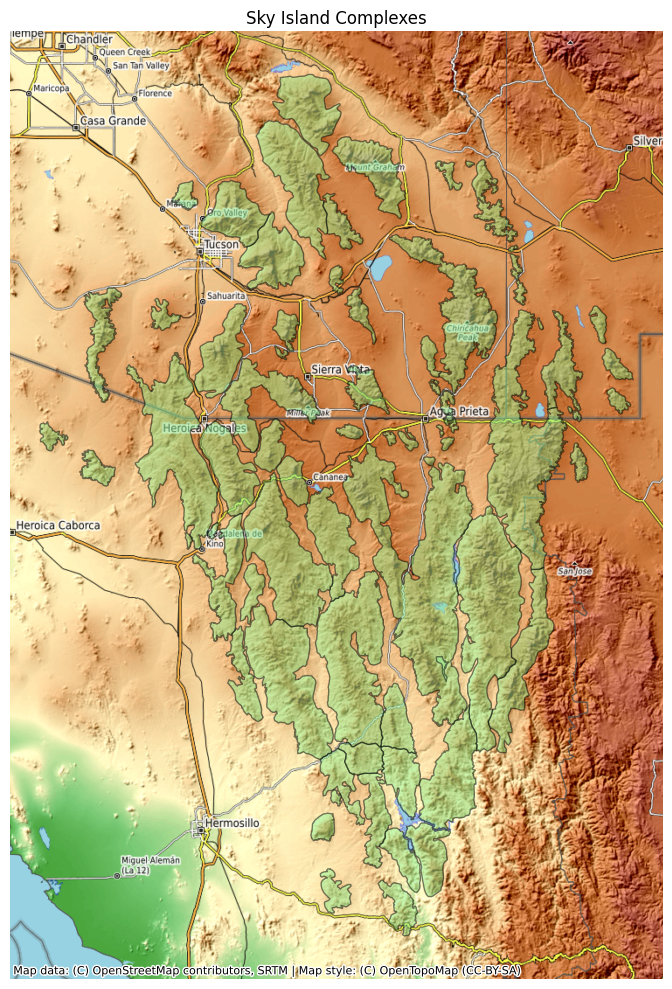

In [8]:
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, edgecolor='black', facecolor='lightgreen', alpha=0.5, linewidth=1)
ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

ax.set_axis_off()
plt.title("Sky Island Complexes")
plt.tight_layout()
plt.show()


In [9]:
df_full = pd.read_excel('../data/perityleae_distribution_data.xlsx', sheet_name='PerityleaeALL12', index_col=0)

col_l = df_full.columns

df_sky_island = pd.read_excel('../data/perityleae_distribution_data.xlsx', sheet_name='Laphamia',header=None, names=col_l, index_col=0)


In [10]:
df_sky_island[['speciesCurated', 'decimallatitude_wgs', 'decimallongitude_wgs', 'countrycode']]

speciesCurated  decimallatitude_wgs  decimallongitude_wgs  \
473593  Perityle aglossa            26.742876           -106.653333   
473594  Perityle aglossa            29.058000           -105.392000   
473595  Perityle aglossa            29.050000           -105.383000   
473596  Perityle aglossa            29.966660           -104.633330   
473597  Perityle aglossa            29.969999           -104.629997   
...                  ...                  ...                   ...   
475712   Perityle vaseyi            28.870000           -102.750000   
475713  Perityle villosa            36.887200           -117.460700   
475714  Perityle villosa            36.886600           -117.456100   
475715  Perityle villosa            36.181029           -117.045355   
475716  Perityle villosa            36.094050           -117.033740   

       countrycode  
473593          MX  
473594          MX  
473595          MX  
473596          US  
473597          US  
...            ...  
475712          MX  
475713          US  
475714          US  
475715          US  
475716          US  

[508 rows x 4 columns]

In [11]:
def plot_species_composition_in_polygons(
    species_df,
    kmz_path,
    lat_col='latitude',
    lon_col='longitude',
    species_col='species',
    basemap=True,
    max_species_legend=50
):
    """
    Plots polygons from a KMZ file, filled with blended colors representing species composition
    from the input dataset. Each species present contributes equally to the polygon's fill color.

    Parameters:
    - species_df: pandas DataFrame with species records (must include lat/lon and species columns)
    - kmz_path: path to the KMZ file
    - lat_col: name of latitude column
    - lon_col: name of longitude column
    - species_col: name of species column
    - basemap: whether to add a topographic basemap
    - max_species_legend: max number of species to show in the legend
    """
    import zipfile
    from xml.dom import minidom
    import geopandas as gpd
    from shapely.geometry import Polygon, Point
    import matplotlib.pyplot as plt
    import contextily as ctx
    import matplotlib.colors as mcolors
    from matplotlib.patches import Patch

    # --- Step 1: Extract polygons from KMZ ---
    with zipfile.ZipFile(kmz_path, 'r') as kmz:
        kml_content = kmz.read('doc.kml')

    doc = minidom.parseString(kml_content)
    placemarks = doc.getElementsByTagName('Placemark')

    poly_names, poly_geoms = [], []
    for pm in placemarks:
        name = pm.getElementsByTagName('name')[0].firstChild.nodeValue
        coords_tags = pm.getElementsByTagName('coordinates')

        for coords_tag in coords_tags:
            coords_text = coords_tag.firstChild.nodeValue.strip()
            coord_pairs = coords_text.split()
            points = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in coord_pairs]
            if len(points) > 2:
                poly_names.append(name)
                poly_geoms.append(Polygon(points))

    poly_gdf = gpd.GeoDataFrame({'name': poly_names, 'geometry': poly_geoms}, crs='EPSG:4326')
    poly_gdf.set_index('name', inplace=True)

    # --- Step 2: Convert species points to GeoDataFrame ---
    points_gdf = gpd.GeoDataFrame(
        species_df.copy(),
        geometry=gpd.points_from_xy(species_df[lon_col], species_df[lat_col]),
        crs='EPSG:4326'
    )

    # --- Step 3: Spatial join to assign points to polygons ---
    joined = gpd.sjoin(points_gdf, poly_gdf, how='inner', predicate='within')

    # --- Step 4: Compute equal-weight species presence matrix ---
    species_presence = joined.groupby(['name', species_col]).size().unstack(fill_value=0)
    species_presence[species_presence > 0] = 1
    species_props = species_presence.div(species_presence.sum(axis=1), axis=0)

    # --- Step 5: Assign unique colors to species ---
    species_list = species_props.columns.tolist()
    colormap = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    species_colors = {
        species: colormap[i % len(colormap)] for i, species in enumerate(species_list)
    }

    # --- Step 6: Blend species colors by equal presence ---
    def blend_color(row):
        rgb = [0, 0, 0]
        for species, prop in row.items():
            c = mcolors.to_rgb(species_colors[species])
            rgb = [r + prop * c[i] for i, r in enumerate(rgb)]
        return tuple(min(1, x) for x in rgb)

    fill_colors = species_props.apply(blend_color, axis=1)

    # --- Step 7: Assign fill colors to polygons (gray fallback) ---
    poly_gdf['color'] = [
        fill_colors.get(name, (0.9, 0.9, 0.9)) for name in poly_gdf.index
    ]
    poly_gdf_plot = poly_gdf.to_crs(epsg=3857)

    # --- Step 8: Plot ---
    fig, ax = plt.subplots(figsize=(12, 10))
    poly_gdf_plot.plot(ax=ax, color=poly_gdf_plot['color'], edgecolor='black', linewidth=1)

    if basemap:
        ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

    ax.set_title("Species Composition in Sky Island Polygons", fontsize=14)
    ax.set_axis_off()

    # --- Step 9: Add species legend ---
    legend_species = species_list[:max_species_legend]
    legend_patches = [
        Patch(color=species_colors[sp], label=sp) for sp in legend_species
    ]
    if len(species_list) > max_species_legend:
        legend_patches.append(Patch(color='gray', label='Other species'))

    ax.legend(handles=legend_patches, title="Species", loc='lower left', fontsize=9, title_fontsize=10)

    plt.tight_layout()
    plt.show()

    return poly_gdf


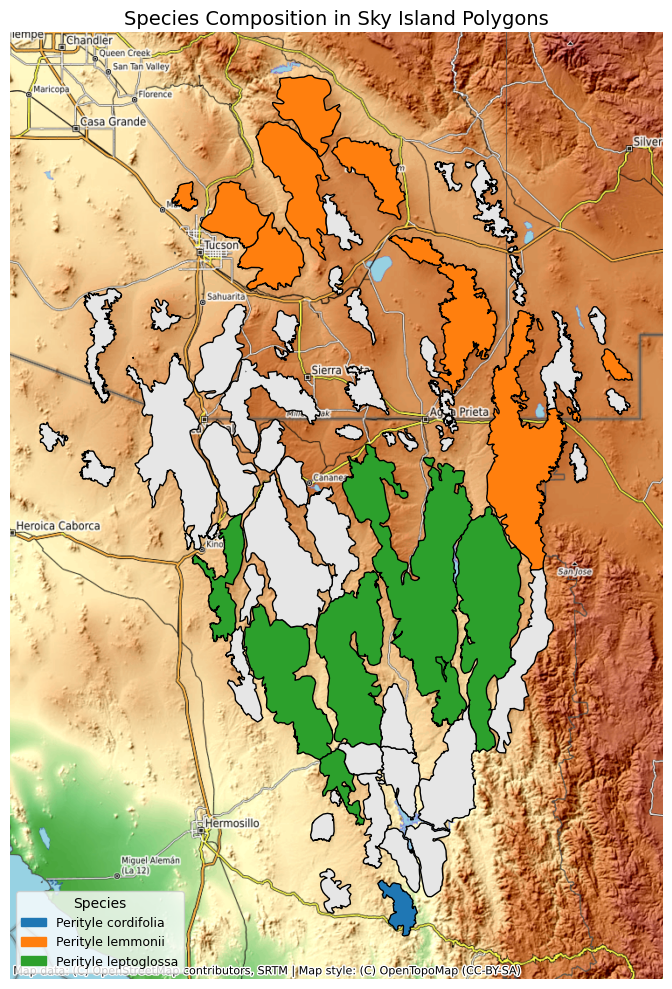

geometry  \
name                                                                          
PELONCILLO                POLYGON ((-108.9621 32.05586, -108.96511 32.05...   
PELONCILLO                POLYGON ((-108.99339 32.20273, -109.00242 32.2...   
PELONCILLO                POLYGON ((-108.98245 32.25574, -108.9837 32.25...   
PELONCILLO                POLYGON ((-109.1085 32.57678, -109.11494 32.57...   
PELONCILLO                POLYGON ((-109.17575 32.69707, -109.17646 32.6...   
...                                                                     ...   
LOS CABALLOS              POLYGON ((-109.80786 29.5561, -109.81616 29.55...   
LA HUERTA                 POLYGON ((-109.7306 29.89659, -109.75352 29.90...   
BATAMOTE                  POLYGON ((-110.12284 29.31877, -110.12832 29.3...   
LAS GUIJAS - LA SENORITA  POLYGON ((-109.27965 29.70763, -109.27934 29.7...   
CERRO EL TIZNADO          POLYGON ((-109.91948 29.56687, -109.95504 29.5...   

                                    color  
name                                       
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
...                                   ...  
LOS CABALLOS              (0.9, 0.9, 0.9)  
LA HUERTA                 (0.9, 0.9, 0.9)  
BATAMOTE                  (0.9, 0.9, 0.9)  
LAS GUIJAS - LA SENORITA  (0.9, 0.9, 0.9)  
CERRO EL TIZNADO          (0.9, 0.9, 0.9)  

[87 rows x 2 columns]

In [12]:
# Assume your dataframe has lat/lon/species columns
plot_species_composition_in_polygons(
    species_df=df_sky_island,
    kmz_path=kmz_filepath,
    lat_col='decimallatitude_wgs',
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated'
)

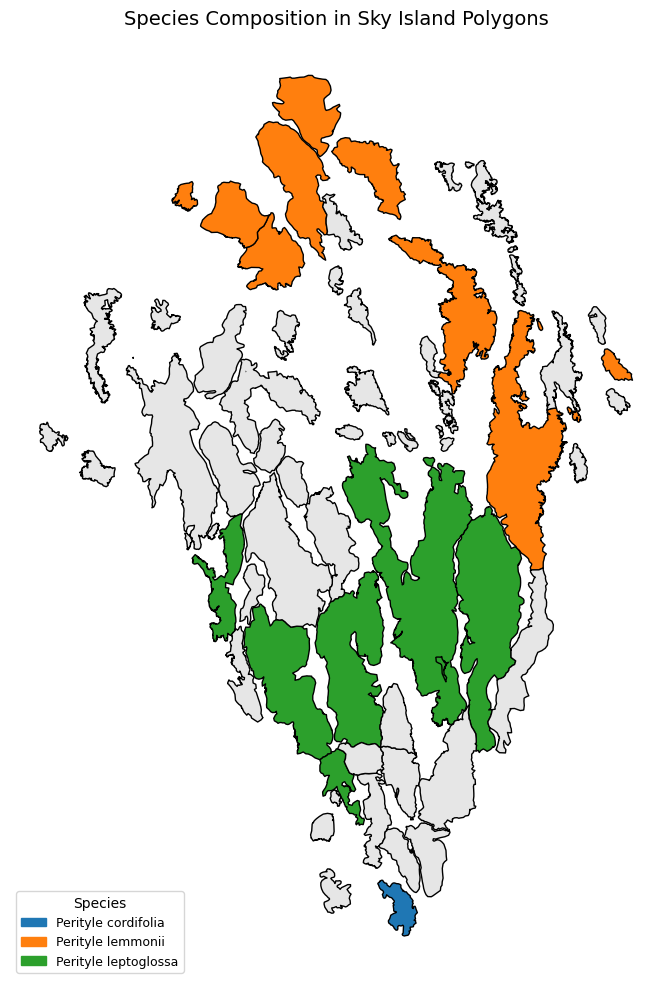

geometry  \
name                                                                          
PELONCILLO                POLYGON ((-108.9621 32.05586, -108.96511 32.05...   
PELONCILLO                POLYGON ((-108.99339 32.20273, -109.00242 32.2...   
PELONCILLO                POLYGON ((-108.98245 32.25574, -108.9837 32.25...   
PELONCILLO                POLYGON ((-109.1085 32.57678, -109.11494 32.57...   
PELONCILLO                POLYGON ((-109.17575 32.69707, -109.17646 32.6...   
...                                                                     ...   
LOS CABALLOS              POLYGON ((-109.80786 29.5561, -109.81616 29.55...   
LA HUERTA                 POLYGON ((-109.7306 29.89659, -109.75352 29.90...   
BATAMOTE                  POLYGON ((-110.12284 29.31877, -110.12832 29.3...   
LAS GUIJAS - LA SENORITA  POLYGON ((-109.27965 29.70763, -109.27934 29.7...   
CERRO EL TIZNADO          POLYGON ((-109.91948 29.56687, -109.95504 29.5...   

                                    color  
name                                       
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
PELONCILLO                (0.9, 0.9, 0.9)  
...                                   ...  
LOS CABALLOS              (0.9, 0.9, 0.9)  
LA HUERTA                 (0.9, 0.9, 0.9)  
BATAMOTE                  (0.9, 0.9, 0.9)  
LAS GUIJAS - LA SENORITA  (0.9, 0.9, 0.9)  
CERRO EL TIZNADO          (0.9, 0.9, 0.9)  

[87 rows x 2 columns]

In [13]:
# Assume your dataframe has lat/lon/species columns
plot_species_composition_in_polygons(
    species_df=df_sky_island,
    kmz_path=kmz_filepath,
    lat_col='decimallatitude_wgs',
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    basemap=False  # turn off contextily for now
)


In [14]:
def plot_geographical_positions(
    df, 
    lat_col='decimallatitude_wgs', 
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    zoom='auto',
    cluster_line=False,
    plot_roads=False,
    plot_rivers=False,
    raster_path=None,
    bbox=None,
    kmz_path=None  # NEW ARGUMENT
):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import rasterio
    from rasterio.plot import show as rio_show
    from cartopy.io.shapereader import Reader
    import cartopy.io.shapereader as shpreader
    from matplotlib import colormaps
    from shapely.geometry import Polygon, Point, box
    import zipfile
    from xml.dom import minidom
    import geopandas as gpd
    import pandas as pd
    import numpy as np

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

    # Filter data to only what's inside the bbox
    if bbox:
        min_lon, max_lon, min_lat, max_lat = bbox
        df = df[
            (df[lon_col] >= min_lon) & (df[lon_col] <= max_lon) &
            (df[lat_col] >= min_lat) & (df[lat_col] <= max_lat)
        ]

    if df.empty:
        print("No data inside bounding box. Nothing to plot.")
        return

    # Raster background
    if raster_path:
        with rasterio.open(raster_path) as src:
            rio_show(src, ax=ax, transform=src.transform)

    # Base map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)

    if plot_rivers:
        ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.7, linewidth=0.5)
    if plot_roads:
        roads_shp = shpreader.natural_earth(category='cultural', name='roads', resolution='10m')
        roads = Reader(roads_shp).geometries()
        ax.add_geometries(roads, crs=projection, edgecolor='brown', facecolor='none', linewidth=0.5, alpha=0.7)

    # Color by species
    species_list = df[species_col].unique()
    cmap = colormaps.get_cmap('tab20')
    color_map = {species: cmap(i / len(species_list)) for i, species in enumerate(species_list)}

    # --- KMZ Polygon Loading ---
    poly_gdf = None
    if kmz_path:
        with zipfile.ZipFile(kmz_path, 'r') as kmz:
            kml_content = kmz.read('doc.kml')
        doc = minidom.parseString(kml_content)
        placemarks = doc.getElementsByTagName('Placemark')

        names, geoms = [], []
        for pm in placemarks:
            name = pm.getElementsByTagName('name')[0].firstChild.nodeValue
            coords_tags = pm.getElementsByTagName('coordinates')
            for coords_tag in coords_tags:
                coords_text = coords_tag.firstChild.nodeValue.strip()
                coords = coords_text.split()
                points = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in coords]
                if len(points) > 2:
                    names.append(name)
                    geoms.append(Polygon(points))

        poly_gdf = gpd.GeoDataFrame({'name': names, 'geometry': geoms}, crs='EPSG:4326')

        # Clip to bbox if provided
        if bbox:
            bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
            poly_gdf = poly_gdf[poly_gdf.intersects(bbox_geom)]
            poly_gdf['geometry'] = poly_gdf['geometry'].intersection(bbox_geom)

        # Join points to polygons
        points_gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs='EPSG:4326')
        joined = gpd.sjoin(points_gdf, poly_gdf, how='inner', predicate='within')

        # Assign dominant species to each polygon
        species_by_polygon = joined.groupby('name')[species_col].agg(lambda x: x.mode()[0])
        poly_gdf = poly_gdf.set_index('name').join(species_by_polygon).reset_index()

        # Plot polygons with fill transparency and opaque borders
        for _, row in poly_gdf.iterrows():
            species = row[species_col] if not pd.isnull(row[species_col]) else None
            color = color_map.get(species, (0.8, 0.8, 0.8))

            # Fill with transparency
            ax.add_geometries(
                [row.geometry],
                crs=projection,
                facecolor=color,
                edgecolor='none',
                alpha=0.4
            )

            # Opaque edge
            ax.add_geometries(
                [row.geometry],
                crs=projection,
                facecolor='none',
                edgecolor='black',
                linewidth=0.8,
                alpha=1.0
            )

    # --- Plot species points ON TOP ---
    for species in species_list:
        subset = df[df[species_col] == species]
        ax.scatter(
            subset[lon_col], subset[lat_col],
            color=color_map[species],
            s=50, alpha=0.8, edgecolor='k',
            label=species,
            transform=ccrs.PlateCarree()
        )

        if cluster_line and len(subset) > 1:
            subset = subset.sort_values(by=[lat_col, lon_col])
            for i in range(len(subset) - 1):
                ax.plot(
                    [subset.iloc[i][lon_col], subset.iloc[i + 1][lon_col]],
                    [subset.iloc[i][lat_col], subset.iloc[i + 1][lat_col]],
                    color=color_map[species],
                    linewidth=1.5, alpha=0.6,
                    transform=ccrs.PlateCarree()
                )

    # Set extent
    if bbox:
        ax.set_extent(bbox, crs=projection)
    else:
        min_lat, max_lat = df[lat_col].min(), df[lat_col].max()
        min_lon, max_lon = df[lon_col].min(), df[lon_col].max()
        lat_buffer = (max_lat - min_lat) * 0.1 if max_lat > min_lat else 1
        lon_buffer = (max_lon - min_lon) * 0.1 if max_lon > min_lon else 1
        extent = [min_lon - lon_buffer, max_lon + lon_buffer, min_lat - lat_buffer, max_lat + lat_buffer]
        ax.set_extent(extent, crs=projection)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    ax.set_title('Geographical Positions by Species')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, title='Species', frameon=True)
    plt.tight_layout()
    plt.show()


In [15]:
raster_filepath = '../data/HYP_HR_SR_OB_DR/HYP_HR_SR_OB_DR.tif'

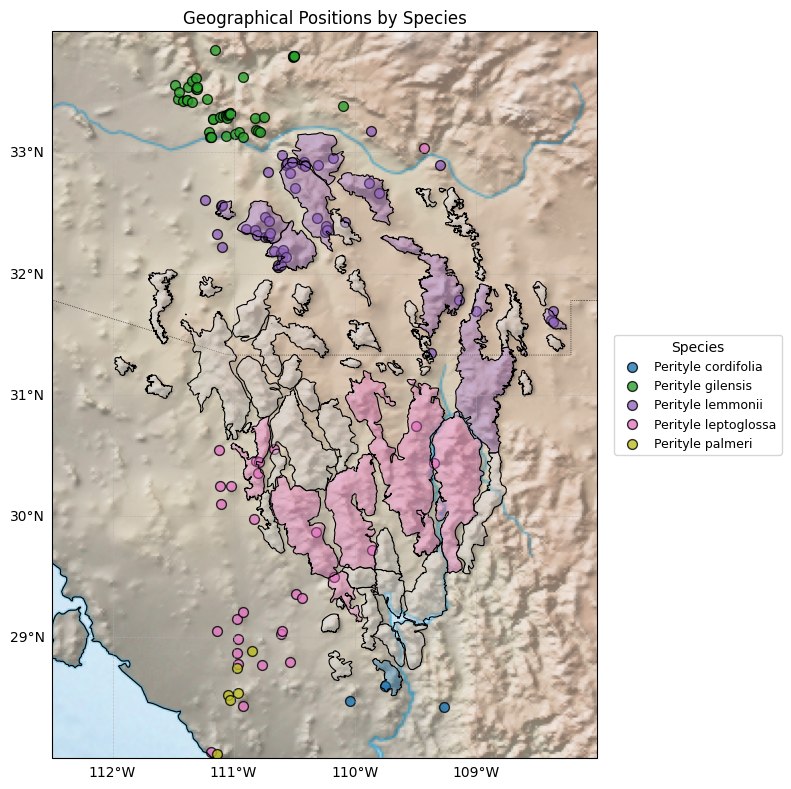

In [16]:
plot_geographical_positions(
    df=df_sky_island,
    lat_col='decimallatitude_wgs',
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    kmz_path=kmz_filepath,
    raster_path=raster_filepath,
    bbox=[-112.5, -108, 28, 34]
)


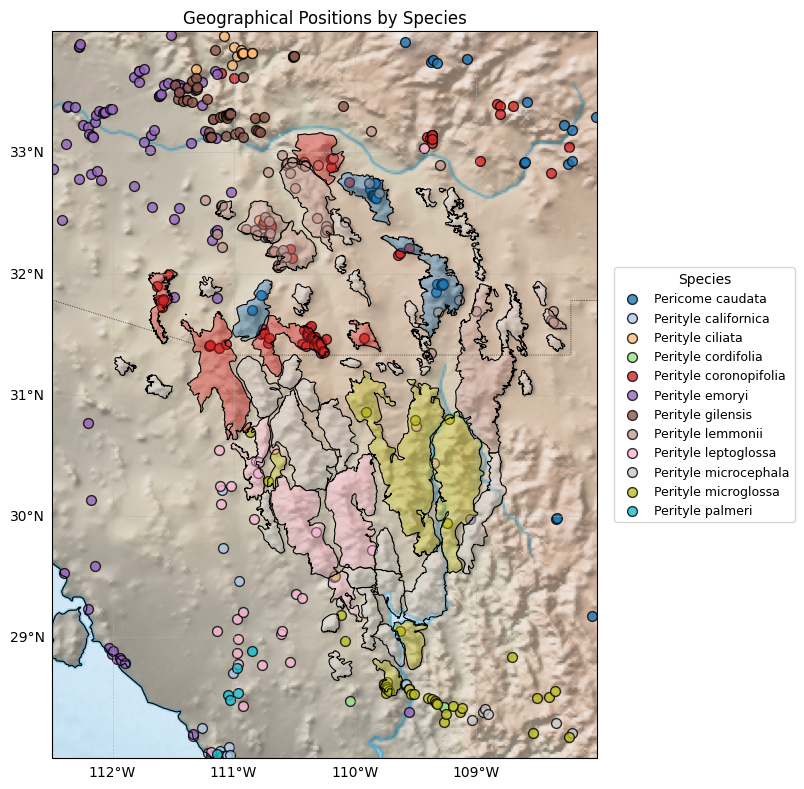

In [17]:
plot_geographical_positions(
    df=df_full,
    lat_col='decimallatitude_wgs',
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    kmz_path=kmz_filepath,
    raster_path=raster_filepath,
    bbox=[-112.5, -108, 28, 34]
)


In [28]:
def plot_geographical_positions(
    df, 
    lat_col='decimallatitude_wgs', 
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    zoom='auto',
    cluster_line=False,
    plot_roads=False,
    plot_rivers=False,
    raster_path=None,
    bbox=None,
    kmz_path=None
):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import rasterio
    from rasterio.plot import show as rio_show
    from cartopy.io.shapereader import Reader
    import cartopy.io.shapereader as shpreader
    from matplotlib import colormaps
    from shapely.geometry import Polygon, Point, box
    import zipfile
    from xml.dom import minidom
    import geopandas as gpd
    import pandas as pd
    import numpy as np

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

    # Filter data inside bbox
    if bbox:
        min_lon, max_lon, min_lat, max_lat = bbox
        df = df[
            (df[lon_col] >= min_lon) & (df[lon_col] <= max_lon) &
            (df[lat_col] >= min_lat) & (df[lat_col] <= max_lat)
        ]

    if df.empty:
        print("No data inside bounding box. Nothing to plot.")
        return

    # Raster background
    if raster_path:
        with rasterio.open(raster_path) as src:
            rio_show(src, ax=ax, transform=src.transform)

    # Base map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)

    if plot_rivers:
        ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.7, linewidth=0.5)
    if plot_roads:
        roads_shp = shpreader.natural_earth(category='cultural', name='roads', resolution='10m')
        roads = Reader(roads_shp).geometries()
        ax.add_geometries(roads, crs=projection, edgecolor='brown', facecolor='none', linewidth=0.5, alpha=0.7)

    # Color by species
    species_list = df[species_col].unique()
    cmap = colormaps.get_cmap('tab20')
    color_map = {species: cmap(i / len(species_list)) for i, species in enumerate(species_list)}

    # --- KMZ Polygon Loading ---
    poly_gdf = None
    if kmz_path:
        with zipfile.ZipFile(kmz_path, 'r') as kmz:
            kml_content = kmz.read('doc.kml')
        doc = minidom.parseString(kml_content)
        placemarks = doc.getElementsByTagName('Placemark')

        names, geoms = [], []
        for pm in placemarks:
            name = pm.getElementsByTagName('name')[0].firstChild.nodeValue
            coords_tags = pm.getElementsByTagName('coordinates')
            for coords_tag in coords_tags:
                coords_text = coords_tag.firstChild.nodeValue.strip()
                coords = coords_text.split()
                points = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in coords]
                if len(points) > 2:
                    names.append(name)
                    geoms.append(Polygon(points))

        poly_gdf = gpd.GeoDataFrame({'name': names, 'geometry': geoms}, crs='EPSG:4326')

        # Clip to bbox if provided
        if bbox:
            bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
            poly_gdf = poly_gdf[poly_gdf.intersects(bbox_geom)]
            poly_gdf['geometry'] = poly_gdf['geometry'].intersection(bbox_geom)

        # Join points to polygons
        points_gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs='EPSG:4326')
        joined = gpd.sjoin(points_gdf, poly_gdf, how='inner', predicate='within')

        # Assign all species to each polygon
        species_by_polygon = joined.groupby('name')[species_col].agg(lambda x: list(x.unique()))
        poly_gdf = poly_gdf.set_index('name').join(species_by_polygon).reset_index()

        # Plot polygons
        for _, row in poly_gdf.iterrows():
            species_list_in_poly = row[species_col] if isinstance(row[species_col], list) else []
            if not species_list_in_poly:
                species_list_in_poly = []

            num_species = len(species_list_in_poly)
            if num_species == 0:
                # Gray if no species
                ax.add_geometries([row.geometry], crs=projection,
                                  facecolor=(0.8, 0.8, 0.8), edgecolor='black', alpha=0.4, zorder=2)
            else:
                # Split polygon horizontally into strips
                minx, miny, maxx, maxy = row.geometry.bounds
                height = (maxy - miny) / num_species

                for i, species in enumerate(species_list_in_poly):
                    color = color_map.get(species, (0.5, 0.5, 0.5))
                    strip = box(
                        minx,
                        miny + i * height,
                        maxx,
                        miny + (i + 1) * height
                    ).intersection(row.geometry)

                    ax.add_geometries(
                        [strip],
                        crs=projection,
                        facecolor=color,
                        edgecolor='none',
                        alpha=0.7, zorder=2
                    )

            # Opaque polygon boundary
            ax.add_geometries(
                [row.geometry],
                crs=projection,
                facecolor='none',
                edgecolor='black',
                linewidth=0.8,
                alpha=1.0, zorder=2
            )

    # --- Plot species points ---
    for species in species_list:
        subset = df[df[species_col] == species]
        ax.scatter(
            subset[lon_col], subset[lat_col],
            color=color_map[species],
            s=50, alpha=0.8, edgecolor='k',
            label=species,
            transform=ccrs.PlateCarree(), zorder=3
        )

        if cluster_line and len(subset) > 1:
            subset = subset.sort_values(by=[lat_col, lon_col])
            for i in range(len(subset) - 1):
                ax.plot(
                    [subset.iloc[i][lon_col], subset.iloc[i + 1][lon_col]],
                    [subset.iloc[i][lat_col], subset.iloc[i + 1][lat_col]],
                    color=color_map[species],
                    linewidth=1.5, alpha=0.6,
                    transform=ccrs.PlateCarree(), zorder=3
                )

    # Set extent
    if bbox:
        ax.set_extent(bbox, crs=projection)
    else:
        min_lat, max_lat = df[lat_col].min(), df[lat_col].max()
        min_lon, max_lon = df[lon_col].min(), df[lon_col].max()
        lat_buffer = (max_lat - min_lat) * 0.1 if max_lat > min_lat else 1
        lon_buffer = (max_lon - min_lon) * 0.1 if max_lon > min_lon else 1
        extent = [min_lon - lon_buffer, max_lon + lon_buffer, min_lat - lat_buffer, max_lat + lat_buffer]
        ax.set_extent(extent, crs=projection)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    ax.set_title('Geographical Positions by Species')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, title='Species', frameon=True)
    plt.tight_layout()
    plt.show()


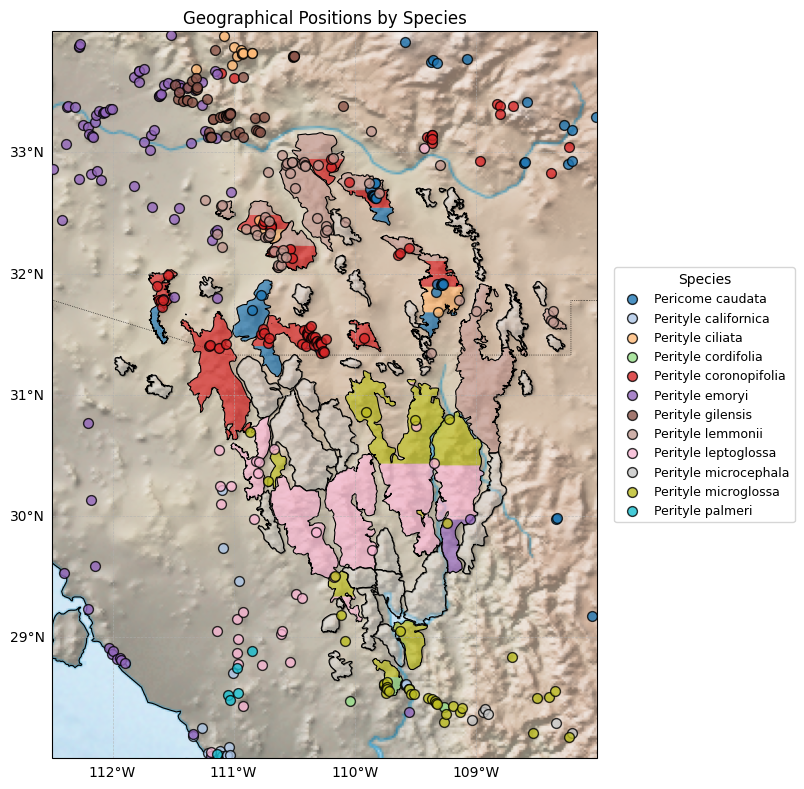

In [29]:
plot_geographical_positions(
    df=df_full,
    lat_col='decimallatitude_wgs',
    lon_col='decimallongitude_wgs',
    species_col='speciesCurated',
    kmz_path=kmz_filepath,
    raster_path=raster_filepath,
    bbox=[-112.5, -108, 28, 34]
)
